In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib
import seaborn as sns
from datetime import time
from sklearn import cluster
from geopy.geocoders import Nominatim
from geopy.distance import vincenty
from datetime import datetime,timedelta
from datetime import timedelta
import datetime as dt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.cluster import DBSCAN
geolocator = Nominatim()
%matplotlib inline

# 1. Data Loading and Data Preparation

In [2]:
#Load data and get the latitude and longitude of the office address
df = pd.read_json('./data.json',lines = True)
office = geolocator.geocode("Treustraße 22 Vienna")

In [3]:
office.point

Point(48.2286111, 16.3669658109802, 0.0)

In [4]:
df.head()

,lat,lon,ts,type
0,48.23048,16.36510,2017-02-06 00:15:43,IN
1,48.23088,16.36457,2017-02-06 00:29:20,IN
2,48.22783,16.36765,2017-02-06 00:30:31,IN
3,48.23078,16.36477,2017-02-06 00:33:23,OUT
4,48.23111,16.36465,2017-02-06 01:02:29,IN


In [5]:
# What types of features are present
df.dtypes

lat     float64
lon     float64
ts       object
type     object
dtype: object

In [6]:
# How many 'IN', 'OUT'
df.type.value_counts()

OUT    3008
IN     2946
Name: type, dtype: int64

In [7]:
#Join 'lat' and 'lon' into a tuple called 'location'
df['location'] = df.apply(lambda row:(row['lat'],row['lon']),axis=1)
#Convert date-time string to date-time object
df['timestamp'] = df['ts'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
#Create a column for just the date of each entry
df['date'] = df['timestamp'].apply(lambda x: x.date())
# Column for just the day of the week for each entry
df['dow'] = df['timestamp'].apply(lambda x: x.weekday())
# Column for just the time of each entry
df['tod'] = df['timestamp'].apply(lambda x : x.time())

In [8]:
#What is the range of dates represented by the data
df['date'].unique()

array([datetime.date(2017, 2, 6), datetime.date(2017, 2, 7),
       datetime.date(2017, 2, 8), datetime.date(2017, 2, 9),
       datetime.date(2017, 2, 10)], dtype=object)

In [9]:
#Notice the dates represent a working week from Monday to Friday

In [10]:
#Sort the data frame by date-time
df.sort_values(by= 'timestamp',inplace = True)
#Reset index such that the index is in ascending order
df.reset_index(drop = True,inplace = True)
# The 'IN' event is registered as +1 and 'OUT' event is registered as -1 
df['diff'] = df['type'].apply(lambda x: 1 if x == 'IN' else -1)
# The 'distance' from office
df['distance'] = df['location'].apply(lambda x : vincenty((office.latitude,office.longitude),x).meters)
# The relative number of vehicles parked at a given time beyond 500m of the office
df['beyond_500m'] = ((df['distance'] >=500)*df['diff']).cumsum()
# The relative number of vehicles parked at a given time between 200m to 500m of the office
df['between_200m_to_500m'] = (((df['distance'] < 500) & (df['distance'] >=200)) * df['diff']).cumsum()
# The relative number of vehicles parked at a given time between 100m to 200m of the office
df['between_100m_to_200m'] = (((df['distance'] < 200)&(df['distance'] >= 100)) * df['diff']).cumsum()
# The relative number of vehicles parked at a given time within 100m of the Office
df['within_100m'] = ((df['distance'] < 100) * df['diff']).cumsum()

In [11]:
df.head()

,lat,lon,ts,type,location,timestamp,date,dow,tod,diff,distance,beyond_500m,between_200m_to_500m,between_100m_to_200m,within_100m
0,48.23048,16.36510,2017-02-06 00:15:43,IN,"(48.23048, 16.3651)",2017-02-06 00:15:43,2017-02-06,0,00:15:43,1,249.801429,0,1,0,0
1,48.23088,16.36457,2017-02-06 00:29:20,IN,"(48.23088, 16.36457)",2017-02-06 00:29:20,2017-02-06,0,00:29:20,1,308.758279,0,2,0,0
2,48.22783,16.36765,2017-02-06 00:30:31,IN,"(48.22783, 16.36765)",2017-02-06 00:30:31,2017-02-06,0,00:30:31,1,100.635851,0,2,1,0
3,48.23078,16.36477,2017-02-06 00:33:23,OUT,"(48.23078, 16.36477)",2017-02-06 00:33:23,2017-02-06,0,00:33:23,-1,291.163189,0,1,1,0
4,48.23111,16.36465,2017-02-06 01:02:29,IN,"(48.23111, 16.36465)",2017-02-06 01:02:29,2017-02-06,0,01:02:29,1,326.817493,0,2,1,0


# 2. Analysis and Plots of the number of parked vehicles within various regions from office

## 2.1 Plot describing the variation of the relative number of parked vehicles agains date-time for different regions

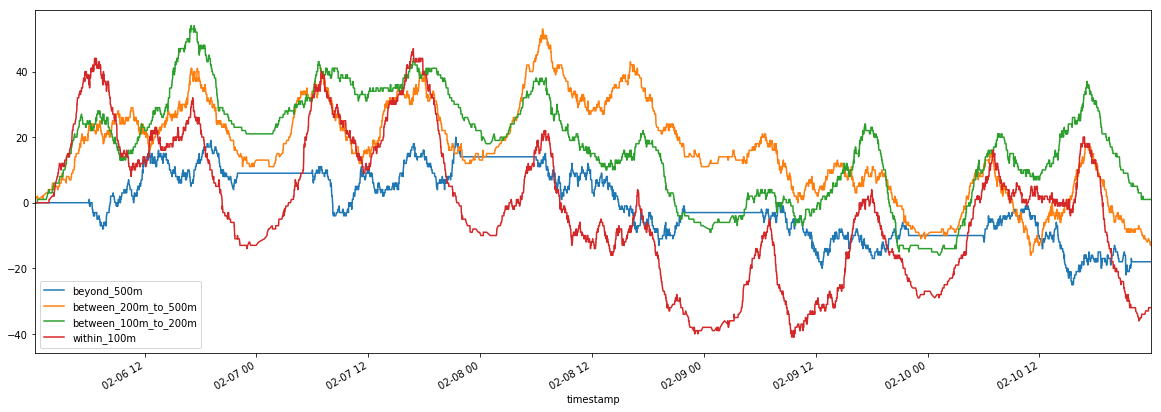

In [12]:
#Plots depicting the relative number of vehicles parked against date-time within 4-different regions
df.plot(x = 'timestamp',y=['beyond_500m','between_200m_to_500m','between_100m_to_200m','within_100m'],figsize=(20,7))
plt.show()

## 2.2 Distribution of distances from office

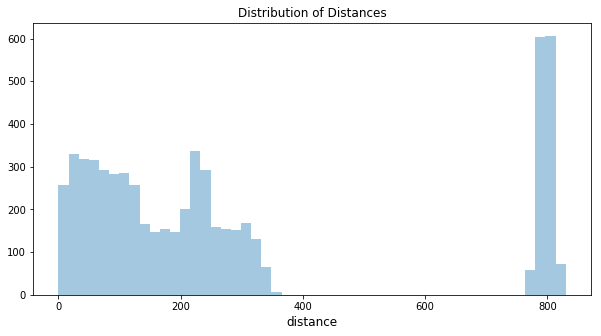

In [13]:
#Distribution of distances from the office
plt.figure(figsize=(10,5))
sns.distplot(df.distance, bins=50, kde=False)
plt.xlabel('distance', fontsize=12)
plt.title('Distribution of Distances')
plt.show()

## 2.3 Plots depicting the relative number of parked vehicles for each region and for each day of the week 

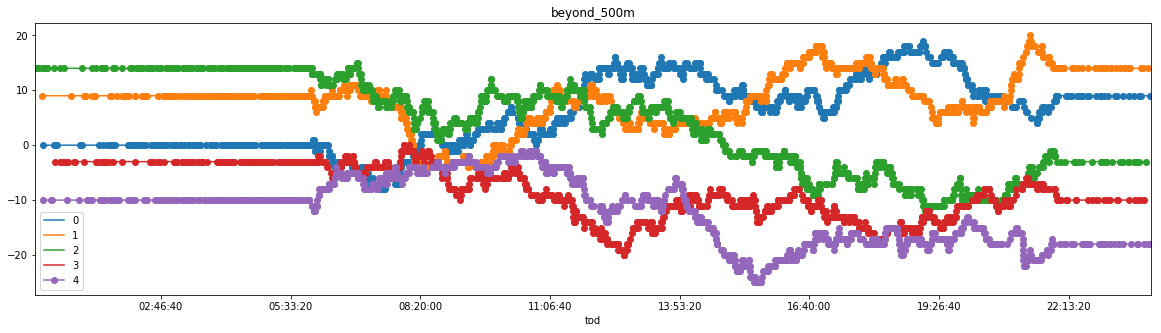

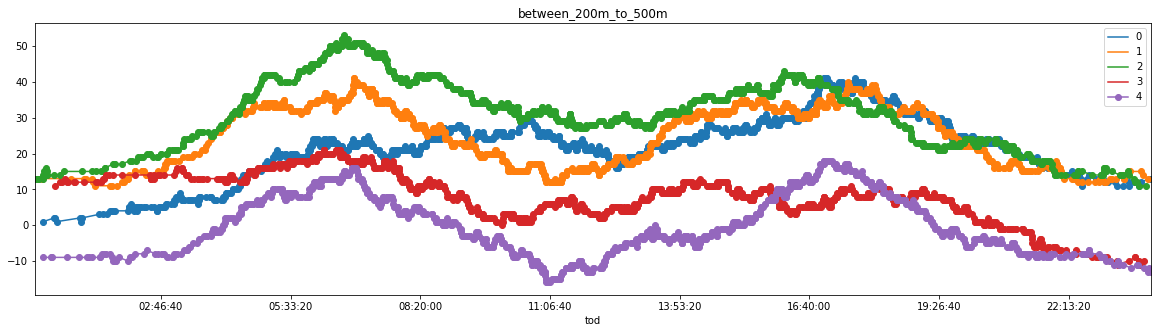

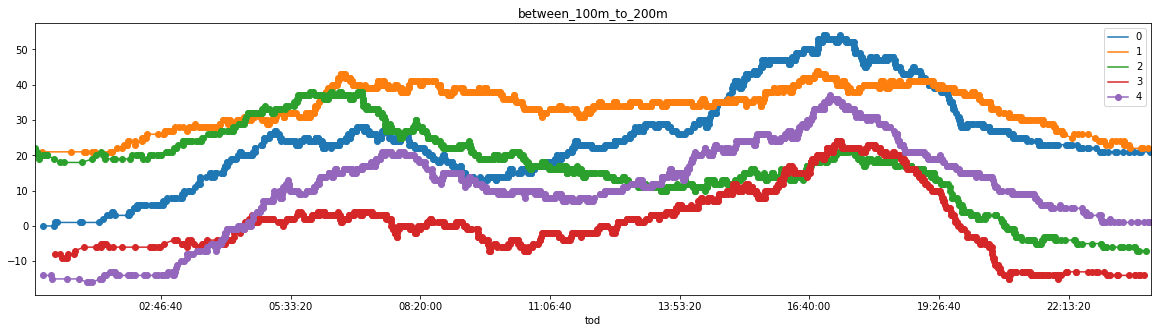

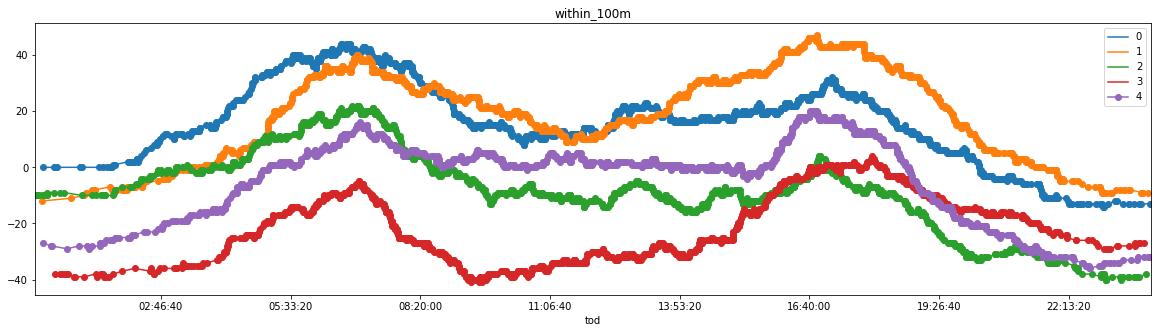

In [14]:
#Plots depicting the relative number of parked vehicles for each region and for each day of the week
regions =['beyond_500m','between_200m_to_500m','between_100m_to_200m','within_100m']
for reg in regions:
    fig,ax=plt.subplots(figsize=(20,5))
    for dow,group in df.groupby('dow'):
        group.plot(x='tod',y=reg,figsize=(20,5),style='o-',label=dow,ax=ax,)
        plt.title(reg)

# 3. Analysis of the times when minimum number of vehicles are parked

In [15]:
#Since an employee only wakes up after 6.30am and should arrive by 10am for the meeting and
#taking into consideration the time of 1.5hrs to reach the destination after waking up. The time window to be
#considered lies between 07:30 to 10:00
s_time = time(7,30)
e_time = time(10,0)

In [16]:
# Select the row's corresponding to the time interval of interest and define a reduced data frame (df_red)
df_red = df[(df.tod >= s_time) & (df.tod <= e_time)]

In [17]:
df_red.head()

,lat,lon,ts,type,location,timestamp,date,dow,tod,diff,distance,beyond_500m,between_200m_to_500m,between_100m_to_200m,within_100m
287,48.22870,16.36701,2017-02-06 07:30:22,OUT,"(48.2287, 16.36701)",2017-02-06 07:30:22,2017-02-06,0,07:30:22,-1,10.416125,-8,20,26,36
288,48.22949,16.36608,2017-02-06 07:30:36,IN,"(48.22949, 16.36608)",2017-02-06 07:30:36,2017-02-06,0,07:30:36,1,117.822062,-8,20,27,36
289,48.22902,16.36663,2017-02-06 07:31:39,IN,"(48.22902, 16.36663)",2017-02-06 07:31:39,2017-02-06,0,07:31:39,1,51.862798,-8,20,27,37
290,48.23081,16.36464,2017-02-06 07:32:03,OUT,"(48.23081, 16.36464)",2017-02-06 07:32:03,2017-02-06,0,07:32:03,-1,299.400337,-8,19,27,37
291,48.22920,16.36627,2017-02-06 07:32:26,OUT,"(48.2292, 16.36627)",2017-02-06 07:32:26,2017-02-06,0,07:32:26,-1,83.428690,-8,19,27,36


## 3.1 Times for each week day and region when the number of vehicles parked is at a minimum

In [18]:
#Find the time where the number of parked vehicles are at a minimum for the different regions and for 
#each day of the week, within the time of interest.
regions =['beyond_500m','between_200m_to_500m','between_100m_to_200m','within_100m']
week = ['Mon','Tue','Wed','Thu','Fri']
df_min = pd.DataFrame(columns=regions, index=week)
for reg in regions:
    for dow,group in df_red.groupby('dow'):
        df_min.loc[week[dow],reg] = df_red['tod'][group[reg].argmin()]
df_min    

,beyond_500m,between_200m_to_500m,between_100m_to_200m,within_100m
Mon,07:30:22,07:33:11,09:20:30,09:28:06
Tue,08:15:11,09:37:26,08:55:07,09:57:34
Wed,08:41:58,09:54:02,09:35:43,09:49:14
Thu,09:11:29,09:56:58,09:48:44,09:25:34
Fri,07:35:05,09:45:17,09:44:26,08:47:39


## 3.2 The approximate optimal times to set up alarms for each week-day and for parking in each region

In [19]:
for i in range(df_min.shape[0]):
    for j in range(df_min.shape[1]):
        df_min.iloc[i,j] = (( dt.datetime(2000,1,1,hour = df_min.iloc[i,j].hour,minute = df_min.iloc[i,j].minute,second =df_min.iloc[i,j].second )- pd.Timedelta(hours = 1.5))).time()
df_min

,beyond_500m,between_200m_to_500m,between_100m_to_200m,within_100m
Mon,06:00:22,06:03:11,07:50:30,07:58:06
Tue,06:45:11,08:07:26,07:25:07,08:27:34
Wed,07:11:58,08:24:02,08:05:43,08:19:14
Thu,07:41:29,08:26:58,08:18:44,07:55:34
Fri,06:05:05,08:15:17,08:14:26,07:17:39


# 4. Violin Plot depicting the distribution of parked vehicles across different regions and day of the week

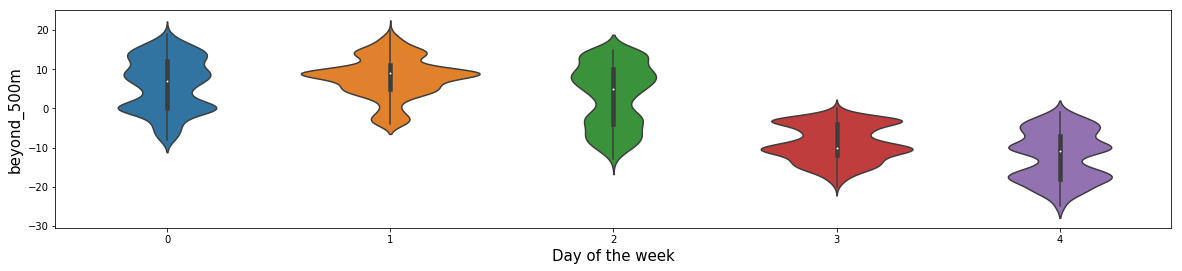

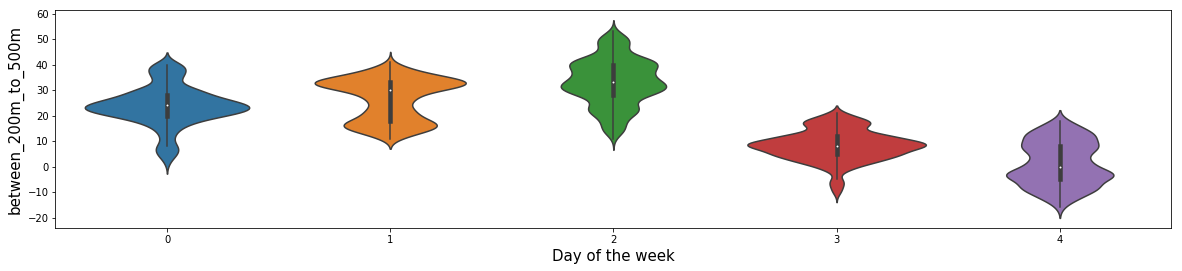

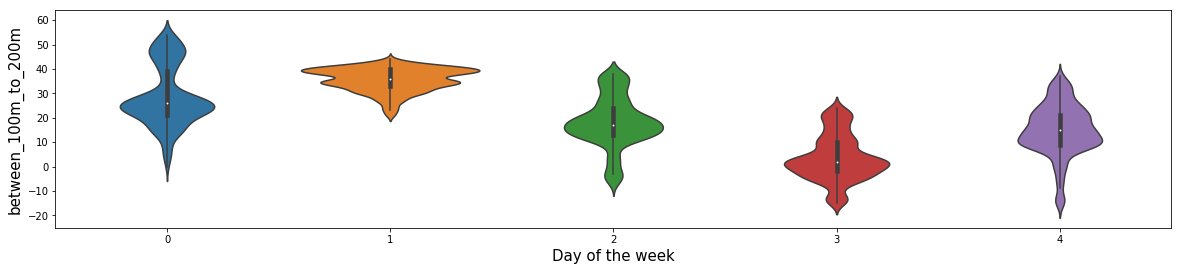

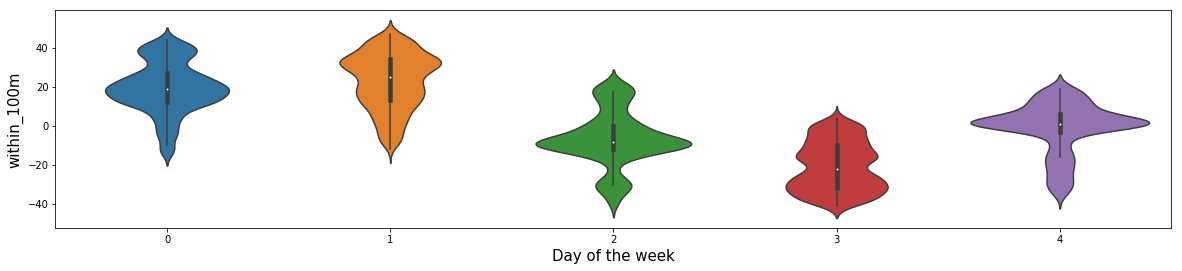

In [20]:
#Violin Plot depicting the distribution of parked vehicles across different regions and day of the week
region = ['beyond_500m','between_200m_to_500m','between_100m_to_200m','within_100m']
for reg in region:
    var_name = "Day of the week"
    col_order = np.sort(df['dow'].unique()).tolist()
    plt.figure(figsize=(20,4))
    sns.violinplot( y=reg,x='dow', data=df, order=col_order)
    plt.xlabel(var_name, fontsize=15)
    plt.ylabel(reg, fontsize=15)
plt.tight_layout
plt.show()

# 5. Estimation of parking-lot locations and their occupancy analysis via K-means clustering

In [21]:
# Compute the k-means clusters (k = 200) for the lat,lon pair
#in order to estimate the locations of the parking lots (here represented by the centroids)
X = df.as_matrix(columns=['lat', 'lon'])
k = 200
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=200, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
# Array of coordinates of the centroids computed by k-means algorithm
centroids_K = kmeans.cluster_centers_
#Column for the estimated parking lot label (computed via K-means) corresponding to each entry
df['label_K'] = kmeans.labels_

## 5.1 Plot of the locations of the estimated parking lots

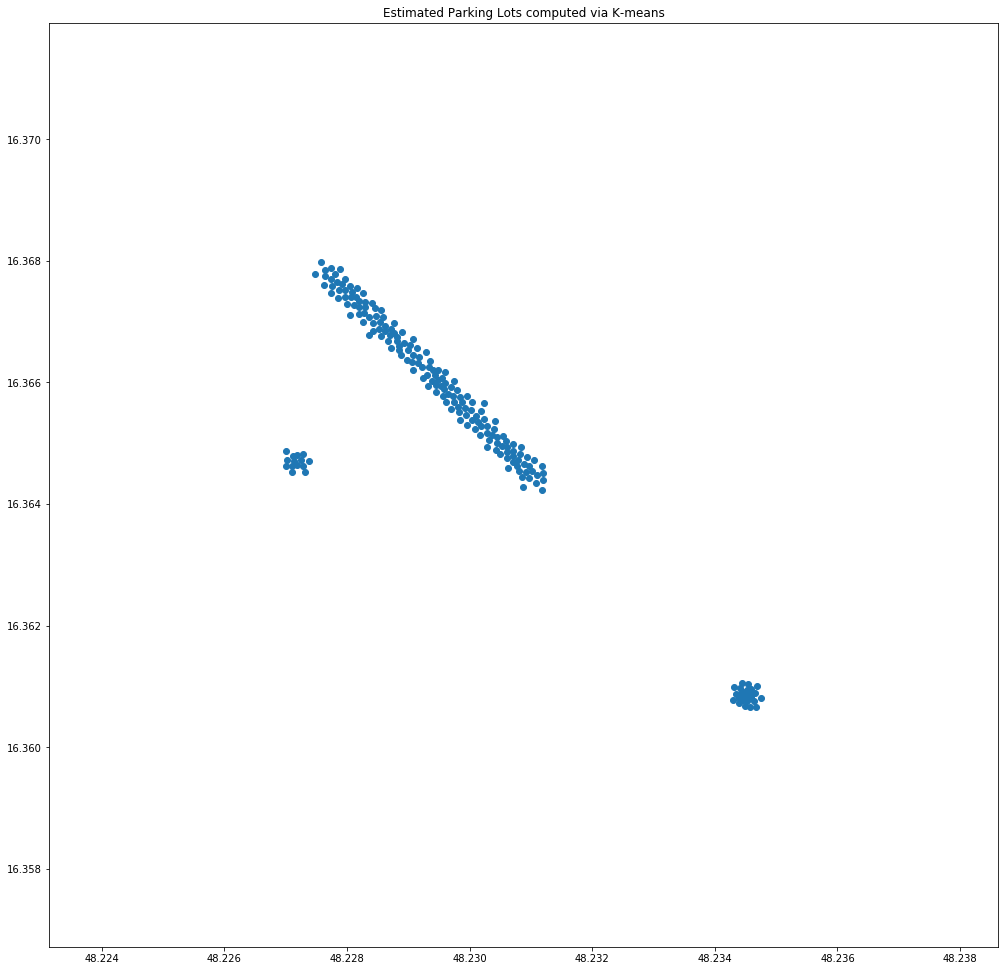

In [23]:
#Plot of the locations of the estimated parking lots
plt.figure(figsize = (17,17))
plt.scatter(*zip(*centroids_K))
plt.title('Estimated Parking Lots computed via K-means')
plt.show()

## 5.2 Analysis of the vacant duration of each estimated parking lot

In [24]:
#This algorithm computes the total duration: by summing over the intervals between the type 'OUT' and 'IN' in that order
# Since this is only an estimation of the parking lots, there is bound to be some error
dur_K = {}
for i in range(len(df)):
    if df['type'][i] == 'OUT':
        if df['label_K'][i] not in dur_K:
            dur_K[df['label_K'][i]] = [df['timestamp'][i],True,pd.Timedelta(0)]
        elif not dur_K[df['label_K'][i]][1]:
            dur_K[df['label_K'][i]][0],dur_K[df['label_K'][i]][1] = df['timestamp'][i],True
         
    elif df['label_K'][i] in dur_K and dur_K[df['label_K'][i]][1]:
        dur_K[df['label_K'][i]][1],dur_K[df['label_K'][i]][2] = False, dur_K[df['label_K'][i]][2] + (df['timestamp'][i] - dur_K[df['label_K'][i]][0])
for key, value in dur_K.iteritems():
    if value[1]:
        value[2] = value[2] + (df['timestamp'][len(df)-1] - value[0])

In [25]:
#Compute the total seconds a parking lot was vacant, corresponding centroid label, and the distance from the office
sec_K = [value[2].total_seconds() for value in dur_K.values()]
dist_label_K = [vincenty((office.latitude,office.longitude),centroids_K[x]).meters for x in dur_K] 
label_K = [i for i in dur_K]
df_dur_K = pd.DataFrame({'label':label_K,'dist_from_office':dist_label_K,'duration':sec_K})

### 5.2.1 Relative Plot depicting the vacant times of each parking-lot labeled by the distance from office

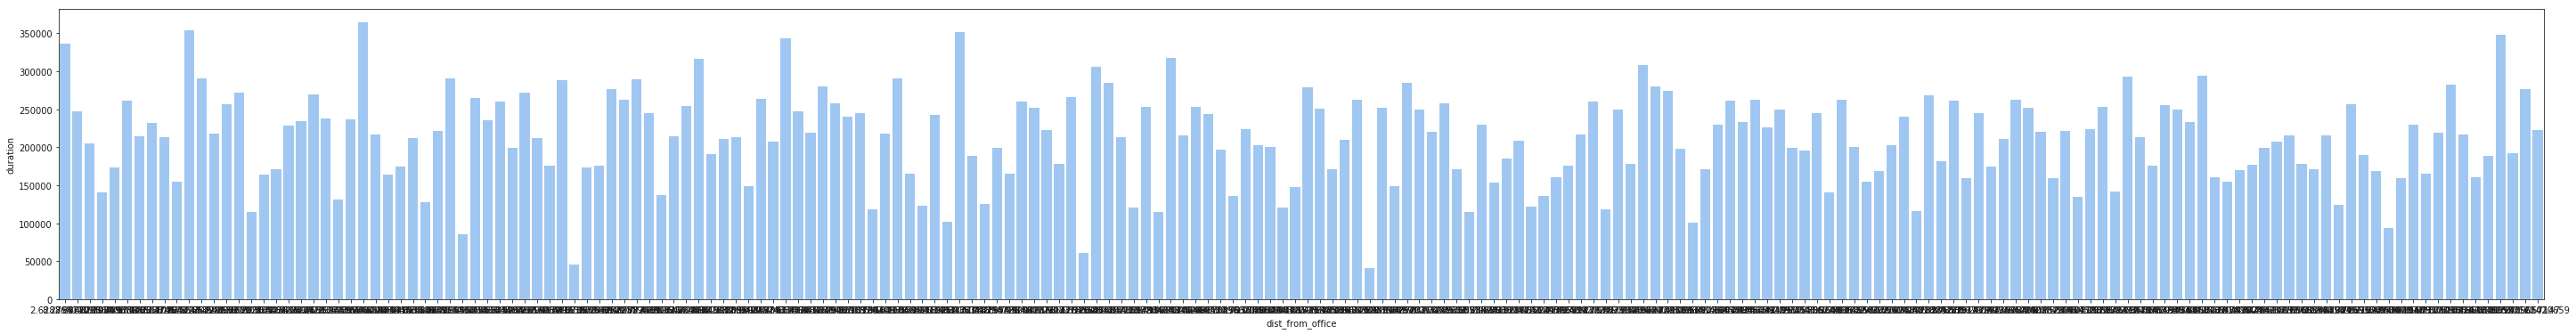

In [26]:
plt.figure(figsize=(50,6))
sns.set_color_codes("pastel")
sns.barplot(x="dist_from_office", y="duration", data=df_dur_K, color="b")
plt.show()

# 6. Estimation of parking-lot locations and their occupancy analysis via DBSCAN Clustering

In [27]:
#Using DBSCAN to compute the clusters (uses haversine metric, more appropriate for 'lat','lon' pairs)
kms_per_radian = 6371.0088 #From earth's radius
epsilon = 0.0031647 / kms_per_radian #distance is tuned to get clusters of around 200 (202)
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(X))
cluster_labels = db.labels_

In [28]:
#number of clusters
num_clusters = len(set(cluster_labels))

In [29]:
num_clusters

202

In [30]:
# Collecting the list of cluster points for each label
clusters = pd.Series([X[cluster_labels == n] for n in range(num_clusters)])

In [31]:
#Centroids of the clusters computed via DBSCAN
centroids_DB = clusters.apply(lambda x: (MultiPoint(x).centroid.x, MultiPoint(x).centroid.y))
#Column for the labels computed via DBSCAN
df['label_DB'] = cluster_labels

## 6.1 Plot of the estimated parking-lots computed via DBSCAN

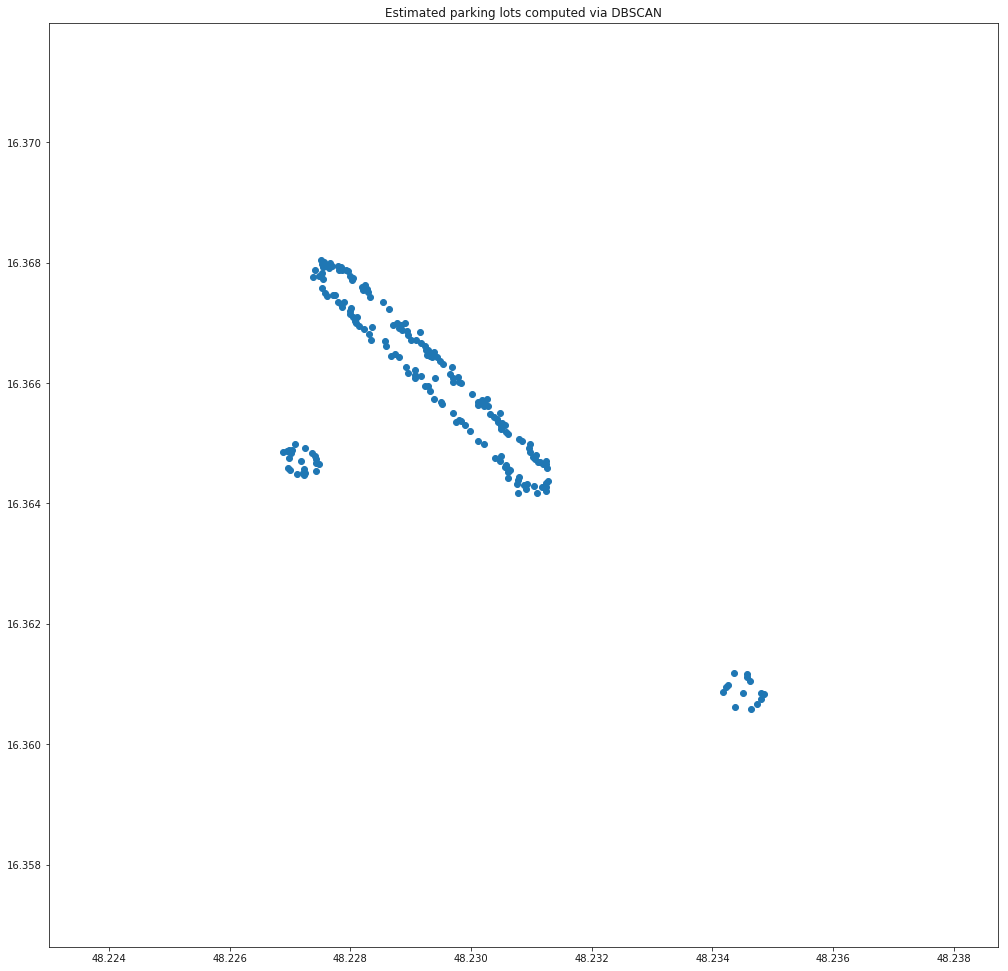

In [32]:
plt.figure(figsize=(17,17))
plt.scatter(*zip(*centroids_DB))
plt.title('Estimated parking lots computed via DBSCAN')
plt.show()

## 6.2 Analysis of the vacant duration of each estimated parking lot

In [33]:
#This algorithm computes the total duration: by summing over the intervals between the type 'OUT' and 'IN' in that order
# Since this is only an estimation of the parking lots, there is bound to be some error
dur_DB = {}
for i in range(len(df)):
    if df['type'][i] == 'OUT':
        if df['label_DB'][i] not in dur_DB:
            dur_DB[df['label_DB'][i]] = [df['timestamp'][i],True,pd.Timedelta(0)]
        elif not dur_DB[df['label_DB'][i]][1]:
            dur_DB[df['label_DB'][i]][0],dur_DB[df['label_DB'][i]][1] = df['timestamp'][i],True
         
    elif df['label_DB'][i] in dur_DB and dur_DB[df['label_DB'][i]][1]:
        dur_DB[df['label_DB'][i]][1],dur_DB[df['label_DB'][i]][2] = False, dur_DB[df['label_DB'][i]][2] + (df['timestamp'][i] - dur_DB[df['label_DB'][i]][0])
for key, value in dur_DB.iteritems():
    if value[1]:
        value[2] = value[2] + (df['timestamp'][len(df)-1] - value[0])
             

In [34]:
#Compute the total seconds a parking lot was vacant, corresponding centroid label, and the distance from the office
sec_DB = [value[2].total_seconds() for value in dur_DB.values()]
label_DB = [label for label in dur_DB]
dist_label_DB = [vincenty((office.latitude,office.longitude),centroids_DB[x]).meters for x in label_DB] 
df_dur_DB = pd.DataFrame({'label':label_DB,'dist_from_office':dist_label_DB,'duration':sec_DB})

### 6.2.1 Relative Plot depicting the vacant times of each parking-lot labeled by the distance from offic

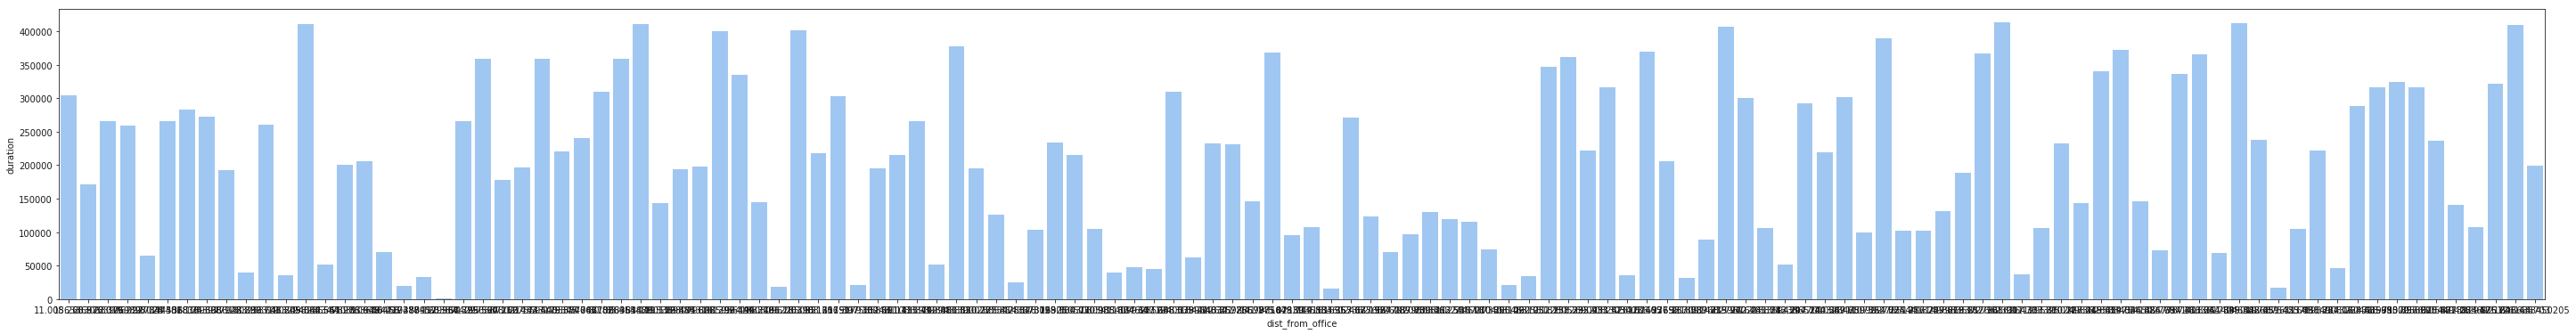

In [35]:
plt.figure(figsize=(50,6))
sns.set_color_codes("pastel")
sns.barplot(x="dist_from_office", y="duration", data=df_dur_DB, color="b")
plt.show()

# 7. Observations and Conclusions

We have analysed the parking data given in the assignment. Firstly, we have made the assumption that the 40% of users of the Parkbob app is a representative sample of the whole population. Our first analysis concerns the number of parked vehicles calculated as a cumulative sum of an 'IN' event (+1) and an 'OUT' event (-1). This is done for 4 differnt regions: 1)beyond 500m's of the office 2)between 200m to 500m of the office 3)between 100m to 200m of the office 4)within 100m of the office. We observe an approximately cyclic curve when these are plotted against the duration the data was collected. This is because of the positive correlation that is expected to exists between two similar times in different days (see 2.1). However, we note that there are differences in different days of the week. As such it is best to analyse each day of the week seperately (see 2.3). We have calculated the time of interest for this problem as between 7.30A.M to 10.00A.M since an employee doesn't wake up before 6AM and has to attend a meeting at 10AM. Considering the time to arrive at the destination from the time an employee wakes up as 1.5hours, we get the the above time interval of interest. 

Reading off the time when a minimum number of vehicles are parked for each day and each region we have arrived at the table 3.1. Substracting 1.5 hours from this gives table 3.2, which, depicts the approximate times an employee should set his/her alarm.

We have also done an analysis of the parking-lots. From the information given that there are ~200 parking lots in the area. We used clustering methods to discern the locations of the parking lots. This is not going to be an exact classification and there is bound to be some overlaps. Both K-means clustering and DBSCAN is used for this purpose. K-means uses euclidean metric which although not appropriate for latitude, longitude pairs, it can be argued that since the points are close it might work. DBSCAN on the otherhand uses haeversine metric which is appropriate. The estimated parking-lots are plotted in 5.1 and 6.1. There is a drastic difference in the result the two methods have yielded. This is owing to the very differnt clustering algorithm they use and the difference in the metrics. 

After estimating the parking-lots we have analysed how they are occupied relative to each other. This is again an approximate computation since we do not have the exact locations and sizes of the parking-lots. However when the total seconds each of the estimated parking-lots were occupied was plotted against the distance from the office, we do not see any discernible trend in both DBSCAN and K-means analysis.

From the violin plots (see 4), we get an illustration of how the distribution of parked vehicles vary across each day and regions. It appears that Thursdays have in general less of number of vehicles parked.

This analysis can be improved if the precise locations of the parking lots are given. It will then be easier and more accurate to analyse the occupancy characteristics. Moreover the traffic information is crucial in determining the optimal time to set the alarm, as this would mean varying times depending on traffic to reach the destination. 